# AlphaMissense Score Analysis

This notebook analyzes gene mutation data and adds AlphaMissense pathogenicity scores to gene results.

In [ ]:
import os
import pandas as pd
import numpy as np
import gzip

# --- Configuration ---
MAF_FILE = "TCGA.LUAD.mutations.txt"
GENE_RESULTS = "gene_results.csv"
AM_ANNOTATION_0 = "/Volumes/T7_Shield/Lab/T7_UCSD/reference/Alphamissense/AlphaMissense_hg19.tsv.gz"
AM_ANNOTATION_1 = "/Volumes/T7_Shield/Lab/T7_UCSD/reference/Alphamissense/AlphaMissense_hg38.tsv.gz"
AM_ANNOTATION_2 = "/Volumes/T7_Shield/Lab/T7_UCSD/reference/Alphamissense/AlphaMissense_isoforms_hg38.tsv.gz"


## Load and Explore Data

First, let's load and explore the mutation and gene result data.

In [12]:
# Function to read and parse MAF file
def load_maf_data(maf_file):
    print(f"Loading MAF data from {maf_file}...")
    maf_data = pd.read_csv(maf_file, sep='\t')
    print(f"Loaded {maf_data.shape[0]} mutations from MAF file")
    return maf_data

# Function to read gene results
def load_gene_results(gene_results_file):
    print(f"Loading gene results from {gene_results_file}...")
    gene_data = pd.read_csv(gene_results_file)
    print(f"Loaded data for {gene_data.shape[0]} genes")
    return gene_data

# Load data
maf_data = load_maf_data(MAF_FILE)
gene_data = load_gene_results(GENE_RESULTS)

# Display sample of the data
print("\nMAF Data Sample:")
maf_data.head()

Loading MAF data from TCGA.LUAD.mutations.txt...
Loaded 224373 mutations from MAF file
Loading gene results from gene_results.csv...
Loaded data for 15520 genes

MAF Data Sample:
Loaded 224373 mutations from MAF file
Loading gene results from gene_results.csv...
Loaded data for 15520 genes

MAF Data Sample:


,patient_id,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,...,SIFT,PolyPhen,DOMAINS,IMPACT,VARIANT_CLASS,FILTER,COSMIC,CALLERS,CONTEXT,NCALLERS
0,TCGA-05-4244,CPN1,0,.,GRCh37,10,101814119,101814119,+,Missense_Mutation,...,deleterious(0),probably_damaging(1),"hmmpanther:PTHR11532:SF7,hmmpanther:PTHR11532,...",MODERATE,SNV,PASS,NONE,SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS,ATCATGGTTAA,5
1,TCGA-05-4244,MKI67,0,.,GRCh37,10,129902901,129902901,+,Silent,...,.,.,"hmmpanther:PTHR21603,hmmpanther:PTHR21603:SF3,...",LOW,SNV,PASS,NONE,MUTECT|MUSE,AATGTGTTGAT,2
2,TCGA-05-4244,NEBL,0,.,GRCh37,10,21104601,21104606,+,In_Frame_Del,...,.,.,"PROSITE_profiles:PS51216,hmmpanther:PTHR11039,...",MODERATE,deletion,PASS,NONE,INDELOCATOR*|VARSCANI*|PINDEL,CAGGAGTTACACTTAAA,3
3,TCGA-05-4244,RP11-445N18.7,0,.,GRCh37,10,45652518,45652518,+,RNA,...,.,.,.,MODIFIER,SNV,PASS,NONE,SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS,GTAAAGACTGA,5
4,TCGA-05-4244,ERCC6,0,.,GRCh37,10,50667200,50667200,+,Silent,...,.,.,"Low_complexity_(Seg):seg,hmmpanther:PTHR10799:...",LOW,SNV,PASS,NONE,SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS,GGCCCGGATGA,5


In [3]:
# Display sample of gene results
print("\nGene Results Sample:")
gene_data.head()


Gene Results Sample:


,gene_name,n_syn,n_mis,n_non,n_spl,exp_syn,exp_mis,exp_non,exp_spl,exp_syn_counts,exp_mis_counts,exp_non_counts,exp_spl_counts,dnds_global,dnds_mis,dnds_non,lr,p_value,q_value,significant
0,KRAS,0,112,1,0,826.263942,2825.355040,256.903360,0,917.0,3239.0,223.0,0,NaN,NaN,NaN,53.674279,2.366411e-13,3.672670e-09,True
1,TP53,7,94,25,6,7831.903014,20884.320055,1598.520263,0,6372.0,18532.0,970.0,0,6.220540,5.035896,17.498109,38.929922,4.392953e-10,3.408932e-06,True
2,KEAP1,1,46,8,1,6721.643228,16909.652927,1378.554901,0,5452.0,14674.0,808.0,0,20.214686,18.285153,39.006895,27.026600,2.006748e-07,9.988036e-04,True
3,EGFR,0,44,1,0,14919.836508,39904.817458,3586.025632,0,12340.0,38252.0,2281.0,0,NaN,NaN,NaN,26.545350,2.574236e-07,9.988036e-04,True
4,STK11,2,21,14,7,2934.874957,6987.624524,545.997922,0,2166.0,6104.0,332.0,0,8.180975,4.410109,37.626745,16.450510,4.993675e-05,1.550037e-01,False


## Extract Transcript IDs for Each Gene

Now, let's extract the transcript IDs for each gene from the MAF file.

In [26]:
def extract_transcript_ids(maf_data):
    """
    Extract transcript IDs for each gene from the MAF file.
    
    Args:
        maf_data (DataFrame): The MAF data containing gene and transcript information
        
    Returns:
        dict: A dictionary mapping gene symbols to lists of transcript IDs
    """
    # Identify the columns containing gene symbols and transcript IDs
    # Common column names in MAF files
    gene_col = None
    transcript_col = None
    
    # Try to find appropriate columns
    for col in maf_data.columns:
        if col.lower() in ['hugo_symbol', 'gene', 'gene_name', 'symbol']:
            gene_col = col
        if col.lower() in ['transcript_id', 'refseq_id', 'ensembl_transcript_id', 'transcript']:
            transcript_col = col
    
    if gene_col is None or transcript_col is None:
        print("Could not identify gene or transcript columns. Available columns:")
        print(maf_data.columns)
        return {}
    
    # Create gene to transcript mapping
    gene_to_transcript = {}
    for _, row in maf_data.dropna(subset=[gene_col, transcript_col]).iterrows():
        gene = row[gene_col]
        transcript = row[transcript_col]
        
        # Strip version number if present (part after the .)
        if isinstance(transcript, str) and '.' in transcript:
            transcript_base = transcript.split('.')[0]
        else:
            transcript_base = transcript
            
        if gene not in gene_to_transcript:
            gene_to_transcript[gene] = []
        
        if transcript_base not in gene_to_transcript[gene]:
            gene_to_transcript[gene].append(transcript_base)
    
    print(f"Extracted transcript IDs for {len(gene_to_transcript)} genes")
    return gene_to_transcript

# Extract transcript IDs
gene_to_transcript = extract_transcript_ids(maf_data)

# Show sample of the mapping
if gene_to_transcript:
    print("\nSample of gene to transcript mapping:")
    for gene, transcripts in list(gene_to_transcript.items())[:5]:
        print(f"{gene}: {transcripts}")

Extracted transcript IDs for 18718 genes

Sample of gene to transcript mapping:
CPN1: ['ENST00000370418']
MKI67: ['ENST00000368654']
NEBL: ['ENST00000377122', 'ENST00000377159']
RP11-445N18.7: ['ENST00000427229']
ERCC6: ['ENST00000355832']


## Process AlphaMissense Annotation Data

Now we'll process the AlphaMissense annotation file to calculate scores for each gene.

In [59]:
import csv, gzip
from collections import defaultdict
from pathlib import Path

def process_alphamissense_data(am_files, gene_to_transcript):
    # ── 1. Prepare look-ups ────────────────────────────────────────────────────
    gene_to_tx = {g: {t.split('.')[0] for t in txs}
                  for g, txs in gene_to_transcript.items()}
    tx_to_gene = defaultdict(list)
    for g, txs in gene_to_tx.items():
        for t in txs:
            tx_to_gene[t].append(g)

    gene_scores = {g: {"exp_mis_scores": 0.0, "exp_mis_am_counts": 0}
                   for g in gene_to_tx}

    # ── 2. Stream every file ───────────────────────────────────────────────────
    for path in map(Path, am_files):
        print(f"\n▶ Processing {path.name}")

        with gzip.open(path, "rt", newline="") as fh:
            reader = csv.reader(fh, delimiter="\t")

            # ---- find the real header ----
            header = None
            for row in reader:                      # read until header found
                if not row:                         # blank line – ignore
                    continue
                if row[0].startswith("#"):
                    if "transcript_id" in row:      # this is the header line
                        header = [c.lstrip("#") for c in row]
                        break                       # stop scanning
                    else:
                        continue                    # still a comment line
                else:
                    # no "#" → first row is already the header (isoform file)
                    header = row
                    break

            if header is None:
                raise RuntimeError(f"{path.name}: no header line found")

            try:
                idx_tx    = header.index("transcript_id")
                idx_score = header.index("am_pathogenicity")
            except ValueError as e:
                raise RuntimeError(f"{path.name}: required columns missing") from e

            # ---- process remaining lines ----
            for row in reader:
                if not row or row[0].startswith("#"):
                    continue           # skip any stray comment/blank lines

                tx_base = row[idx_tx].split(".")[0]
                if tx_base not in tx_to_gene:
                    continue

                try:
                    score = float(row[idx_score])
                except ValueError:
                    continue

                for gene in tx_to_gene[tx_base]:
                    gs = gene_scores[gene]
                    gs["exp_mis_scores"]    += score
                    gs["exp_mis_am_counts"] += 1

        print("   done.")

    return gene_scores



gene_scores = process_alphamissense_data([AM_ANNOTATION_0,AM_ANNOTATION_1,AM_ANNOTATION_2], gene_to_transcript)


▶ Processing AlphaMissense_hg19.tsv.gz
   done.

▶ Processing AlphaMissense_hg38.tsv.gz
   done.

▶ Processing AlphaMissense_hg38.tsv.gz
   done.

▶ Processing AlphaMissense_isoforms_hg38.tsv.gz
   done.

▶ Processing AlphaMissense_isoforms_hg38.tsv.gz
   done.
   done.


In [60]:
gene_scores

{'CPN1': {'exp_mis_scores': 2455.248999999998, 'exp_mis_am_counts': 6042},
 'MKI67': {'exp_mis_scores': 8941.511800000006, 'exp_mis_am_counts': 42604},
 'NEBL': {'exp_mis_scores': 4527.183799999972, 'exp_mis_am_counts': 13674},
 'RP11-445N18.7': {'exp_mis_scores': 0.0, 'exp_mis_am_counts': 0},
 'ERCC6': {'exp_mis_scores': 6947.654200000019, 'exp_mis_am_counts': 19668},
 'DIP2C': {'exp_mis_scores': 12033.039200000007, 'exp_mis_am_counts': 20168},
 'HECTD2': {'exp_mis_scores': 4488.03260000001, 'exp_mis_am_counts': 10242},
 'TLL2': {'exp_mis_scores': 6446.252799999993, 'exp_mis_am_counts': 13486},
 'ATM': {'exp_mis_scores': 0.0, 'exp_mis_am_counts': 0},
 'USP28': {'exp_mis_scores': 5965.456800000007, 'exp_mis_am_counts': 14210},
 'VWA5A': {'exp_mis_scores': 1505.9959999999926, 'exp_mis_am_counts': 5192},
 'MRPL23': {'exp_mis_scores': 411.53589999999923, 'exp_mis_am_counts': 1001},
 'DCDC1': {'exp_mis_scores': 7108.339199999972, 'exp_mis_am_counts': 25732},
 'RAPSN': {'exp_mis_scores': 28

Total genes processed: 18718
Genes with AlphaMissense scores: 16684 (89.1%)
Genes without AlphaMissense scores: 2034 (10.9%)

Score Statistics for Genes with Non-zero Scores:
Min score: 27.37
Max score: 50833.53
Mean score: 2789.41
Median score: 2024.21

Variant Count Statistics:
Min variants: 67
Max variants: 185484
Mean variants: 6826.23
Median variants: 5024


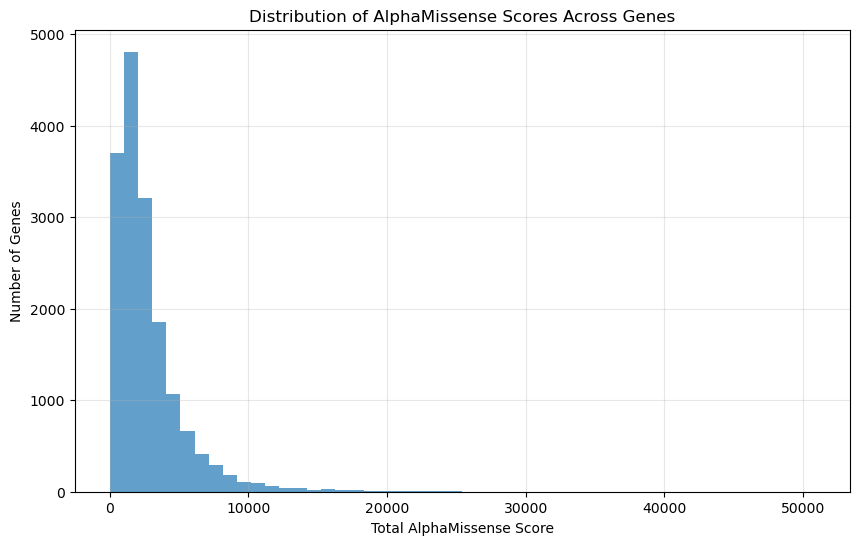

In [ ]:
# Get basic statistics on the gene_scores dictionary
total_genes = len(gene_scores)
genes_with_scores = sum(1 for gene, data in gene_scores.items() if data['exp_mis_scores'] > 0)
genes_without_scores = total_genes - genes_with_scores

print(f"Total genes processed: {total_genes}")
print(f"Genes with AlphaMissense scores: {genes_with_scores} ({genes_with_scores/total_genes*100:.1f}%)")
print(f"Genes without AlphaMissense scores: {genes_without_scores} ({genes_without_scores/total_genes*100:.1f}%)")

# Calculate statistics for genes with scores
if genes_with_scores > 0:
    scores = [data['exp_mis_scores'] for gene, data in gene_scores.items() if data['exp_mis_scores'] > 0]
    counts = [data['exp_mis_am_counts'] for gene, data in gene_scores.items() if data['exp_mis_scores'] > 0]
    
    print("\nScore Statistics for Genes with Non-zero Scores:")
    print(f"Min score: {min(scores):.2f}")
    print(f"Max score: {max(scores):.2f}")
    print(f"Mean score: {sum(scores)/len(scores):.2f}")
    print(f"Median score: {sorted(scores)[len(scores)//2]:.2f}")
    
    print("\nVariant Count Statistics:")
    print(f"Min variants: {min(counts)}")
    print(f"Max variants: {max(counts)}")
    print(f"Mean variants: {sum(counts)/len(counts):.2f}")
    print(f"Median variants: {sorted(counts)[len(counts)//2]}")

# Plot score distribution if scores are available
import matplotlib.pyplot as plt
if genes_with_scores > 0:
    plt.figure(figsize=(10, 6))
    plt.hist(scores, bins=50, alpha=0.7)
    plt.title('Distribution of AlphaMissense Scores Across Genes')
    plt.xlabel('Total AlphaMissense Score')
    plt.ylabel('Number of Genes')
    plt.grid(True, alpha=0.3)
    plt.show()


## Update Gene Results with AlphaMissense Scores

Now we'll add the calculated scores to the gene results table.

In [63]:
def update_gene_results(gene_data, gene_scores):
    """
    Update gene results with AlphaMissense scores.
    
    Args:
        gene_data (DataFrame): Gene results data
        gene_scores (dict): Dictionary with score statistics for each gene
        
    Returns:
        DataFrame: Updated gene results with AlphaMissense scores
    """
    print("Adding AlphaMissense scores to gene results...")
    
    # Identify gene symbol column
    gene_col = None
    for col in gene_data.columns:
        if col.lower() in ['gene', 'hugo_symbol', 'gene_name', 'symbol']:
            gene_col = col
            break
    
    if gene_col is None:
        print("Could not identify gene column in gene results. Available columns:")
        print(gene_data.columns)
        return gene_data
    
    # Check if we need to add exp_non_counts column
    has_exp_non_counts = 'exp_non_counts' in gene_data.columns
    
    # Initialize new columns
    gene_data['exp_mis_scores'] = 0.0
    gene_data['exp_mis_am_counts'] = 0
    gene_data['exp_dn_score'] = 0.0
    
    # Update gene results with scores
    for idx, row in gene_data.iterrows():
        gene = row[gene_col]
        if gene in gene_scores:
            # Add AlphaMissense scores
            gene_data.at[idx, 'exp_mis_scores'] = gene_scores[gene]['exp_mis_scores']
            gene_data.at[idx, 'exp_mis_am_counts'] = gene_scores[gene]['exp_mis_am_counts']
            
            # Calculate exp_dn_score
            if has_exp_non_counts:
                exp_non_counts = gene_data.at[idx, 'exp_non_counts']
                # If exp_non_counts is numeric, add to exp_mis_scores
                if pd.notnull(exp_non_counts) and isinstance(exp_non_counts, (int, float)):
                    gene_data.at[idx, 'exp_dn_score'] = gene_scores[gene]['exp_mis_scores'] + exp_non_counts
                else:
                    gene_data.at[idx, 'exp_dn_score'] = gene_scores[gene]['exp_mis_scores']
            else:
                gene_data.at[idx, 'exp_dn_score'] = gene_scores[gene]['exp_mis_scores']
    
    # Create a summary of the updates
    updated_count = sum([1 for g in gene_data[gene_col] if g in gene_scores])
    print(f"Updated {updated_count} of {len(gene_data)} genes with AlphaMissense scores")
    
    return gene_data

# Update gene results with AlphaMissense scores
updated_gene_data = update_gene_results(gene_data, gene_scores)

# Display updated gene results
print("\nUpdated Gene Results Sample:")
updated_gene_data.head()

Adding AlphaMissense scores to gene results...
Updated 15520 of 15520 genes with AlphaMissense scores

Updated Gene Results Sample:


,gene_name,n_syn,n_mis,n_non,n_spl,exp_syn,exp_mis,exp_non,exp_spl,exp_syn_counts,...,dnds_global,dnds_mis,dnds_non,lr,p_value,q_value,significant,exp_mis_scores,exp_mis_am_counts,exp_dn_score
0,KRAS,0,112,1,0,826.263942,2825.355040,256.903360,0,917.0,...,NaN,NaN,NaN,53.674279,2.366411e-13,3.672670e-09,True,1725.7586,2507,1948.7586
1,TP53,7,94,25,6,7831.903014,20884.320055,1598.520263,0,6372.0,...,6.220540,5.035896,17.498109,38.929922,4.392953e-10,3.408932e-06,True,1120.5145,2569,2090.5145
2,KEAP1,1,46,8,1,6721.643228,16909.652927,1378.554901,0,5452.0,...,20.214686,18.285153,39.006895,27.026600,2.006748e-07,9.988036e-04,True,2161.5357,4110,2969.5357
3,EGFR,0,44,1,0,14919.836508,39904.817458,3586.025632,0,12340.0,...,NaN,NaN,NaN,26.545350,2.574236e-07,9.988036e-04,True,7976.3108,16082,10257.3108
4,STK11,2,21,14,7,2934.874957,6987.624524,545.997922,0,2166.0,...,8.180975,4.410109,37.626745,16.450510,4.993675e-05,1.550037e-01,False,3284.3718,5718,3616.3718


## Save Updated Gene Results

Finally, let's save the updated gene results to a new CSV file.

In [65]:
# Save updated gene results
output_file = "/Volumes/T7_Shield/Lab/T7_UCSD/github_repos/BENG285_team3/project_2/alphamissense/gene_results_with_am_scores.csv"
updated_gene_data.to_csv(output_file, index=False)
print(f"Saved updated gene results to {output_file}")

# Generate summary statistics for the new scores
print("\nSummary Statistics for AlphaMissense Scores:")
score_cols = ['exp_mis_scores', 'exp_mis_am_counts', 'exp_dn_score']
summary = updated_gene_data[score_cols].describe()
summary

Saved updated gene results to /Volumes/T7_Shield/Lab/T7_UCSD/github_repos/BENG285_team3/project_2/alphamissense/gene_results_with_am_scores.csv

Summary Statistics for AlphaMissense Scores:


,exp_mis_scores,exp_mis_am_counts,exp_dn_score
count,15520.000000,15520.000000,15520.000000
mean,2772.670042,6793.008505,3581.595751
std,2968.768049,7139.916199,3645.824279
min,0.000000,0.000000,5.000000
25%,1044.156050,2822.000000,1447.259900
50%,2026.393450,5063.000000,2612.421850
75%,3522.820850,8457.250000,4487.359050
max,50833.533900,185484.000000,89094.000000


In [67]:
# --- Configuration ---
ANNOTATED_MAF_FILE = "/Volumes/T7_Shield/Lab/T7_UCSD/courses/CSE285/project2/TCGA.LUAD.fully_annotated.txt"

## Process Fully Annotated MAF File

Now we'll load the fully annotated MAF file and add AlphaMissense scores to it.

In [68]:
# Load the fully annotated MAF file
print(f"Loading annotated MAF file from {ANNOTATED_MAF_FILE}...")
annotated_maf = pd.read_csv(ANNOTATED_MAF_FILE, sep='\t')
print(f"Loaded {annotated_maf.shape[0]} mutations from annotated MAF file")

# Display columns to understand the structure
print("\nColumns in the annotated MAF file:")
print(annotated_maf.columns.tolist())

# Check if am_pathogenicity already exists
if 'am_pathogenicity' in annotated_maf.columns:
    print("\nam_pathogenicity column already exists. Current non-null values:")
    print(annotated_maf['am_pathogenicity'].notnull().sum())
else:
    print("\nam_pathogenicity column doesn't exist yet. It will be created.")
    
# Filter for missense mutations
missense_variants = annotated_maf[annotated_maf['Variant_Classification'] == 'Missense_Mutation'].copy()
print(f"\nFound {missense_variants.shape[0]} missense mutations")

# If am_pathogenicity exists, filter for ones without scores
if 'am_pathogenicity' in annotated_maf.columns:
    missing_am = missense_variants[missense_variants['am_pathogenicity'].isnull()]
    print(f"Of which {missing_am.shape[0]} are missing AlphaMissense scores")
else:
    missing_am = missense_variants
    print(f"All {missing_am.shape[0]} need AlphaMissense scores")

# Sample of variants to annotate
print("\nSample of variants to annotate:")
missing_am[['Hugo_Symbol', 'Chromosome', 'Start_Position', 'Reference_Allele', 'Tumor_Seq_Allele2']].head()

Loading annotated MAF file from /Volumes/T7_Shield/Lab/T7_UCSD/courses/CSE285/project2/TCGA.LUAD.fully_annotated.txt...


/var/folders/m1/hgskz8dj1d53c9ghp7mby_vh0000gn/T/ipykernel_81436/2536704707.py:3: DtypeWarning: Columns (5,53) have mixed types. Specify dtype option on import or set low_memory=False.
  annotated_maf = pd.read_csv(ANNOTATED_MAF_FILE, sep='\t')


Loaded 224355 mutations from annotated MAF file

Columns in the annotated MAF file:
['patient_id', 'Hugo_Symbol', 'Entrez_Gene_Id', 'Center', 'NCBI_Build', 'Chromosome', 'Start_Position', 'End_Position', 'Strand', 'Variant_Classification', 'Variant_Type', 'Reference_Allele', 'Tumor_Seq_Allele1', 'Tumor_Seq_Allele2', 'dbSNP_RS', 'dbSNP_Val_Status', 'Tumor_Sample_Barcode', 'Matched_Norm_Sample_Barcode', 'Match_Norm_Seq_Allele1', 'Tumor_Validation_Allele1', 'Tumor_Validation_Allele2', 'HGVSc', 'HGVSp', 'Transcript_ID', 't_depth', 't_ref_count', 't_alt_count', 'n_depth', 'Allele', 'Consequence', 'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 'Existing_variation', 'STRAND', 'CANONICAL', 'CCDS', 'ENSP', 'SWISSPROT', 'TREMBL', 'UNIPARC', 'SIFT', 'PolyPhen', 'DOMAINS', 'IMPACT', 'VARIANT_CLASS', 'FILTER', 'COSMIC', 'CALLERS', 'CONTEXT', 'NCALLERS', 'hg38_Chromosome', 'hg38_Start_Position', 'hg38_End_Position', 'hg38_Reference_Allele', 'hg38_Tumor_Seq_Allele1', 'h

,Hugo_Symbol,Chromosome,Start_Position,Reference_Allele,Tumor_Seq_Allele2
128,C1orf222,1,1920356,C,T
288,AGRN,1,981164,C,T
289,AGRN,1,981920,C,T
292,AGRN,1,981235,G,T
293,AGRN,1,981235,G,T


In [72]:
# Function to process AlphaMissense annotation files and extract scores
def process_alphamissense_file(file_path, variants_df, is_hg19=True, is_isoforms=False):
    print(f"\nProcessing AlphaMissense file: {os.path.basename(file_path)}")
    start_time = time.time()
    
    # Create lookup keys based on genome version and file type
    if is_isoforms:
        # For isoforms file, we always use hg38 coordinates
        print("Using hg38 coordinates for isoforms file matching")
        variants_df['lookup_key'] = variants_df.apply(
            lambda row: (f"chr{row['hg38_Chromosome']}", row['hg38_Start_Position'], 
                         row['hg38_Reference_Allele'], row['hg38_Tumor_Seq_Allele2']),
            axis=1
        )
    elif is_hg19:
        variants_df['lookup_key'] = variants_df.apply(
            lambda row: (f"chr{row['Chromosome']}", row['Start_Position'], 
                         row['Reference_Allele'], row['Tumor_Seq_Allele2']),
            axis=1
        )
    else:  # For hg38 files
        # If your file has hg38 columns, you would use those instead:
        if 'hg38_Chromosome' in variants_df.columns:
            variants_df['lookup_key'] = variants_df.apply(
                lambda row: (f"chr{row['hg38_Chromosome']}", row['hg38_Start_Position'], 
                             row['hg38_Reference_Allele'], row['hg38_Tumor_Seq_Allele2']),
                axis=1
            )
        else:
            print("Warning: hg38 coordinates not found in MAF file. Using hg19 coordinates as fallback.")
            variants_df['lookup_key'] = variants_df.apply(
                lambda row: (f"chr{row['Chromosome']}", row['Start_Position'], 
                             row['Reference_Allele'], row['Tumor_Seq_Allele2']),
                axis=1
            )
    
    # Create a lookup dictionary for quick searching
    variant_lookup_keys = set(variants_df['lookup_key'])
    print(f"Created {len(variant_lookup_keys)} lookup keys for matching")
    
    # Initialize results
    results = {}
    found_count = 0
    
    # Process the gzipped TSV file
    with gzip.open(file_path, 'rt') as f:
        # Skip comment lines but keep header line if it starts with #
        header = None
        for line in f:
            line = line.strip()
            if line.startswith('#'):
                if line.startswith('#CHROM') or line.startswith('#transcript_id'):  # This is the header
                    header = line[1:].split('\t')  # Remove the # prefix
                    break
                continue  # Skip other comment lines
            else:  # No header line with #, use the first line as header
                header = line.split('\t')
                break
        
        if not header:
            print("Warning: Could not find header in file. Using default columns.")
            if is_isoforms:
                header = ['CHROM', 'POS', 'REF', 'ALT', 'genome', 'transcript_id', 'protein_variant', 'am_pathogenicity', 'am_class']
            else:
                header = ['CHROM', 'POS', 'REF', 'ALT', 'genome', 'uniprot', 'transcript', 
                          'aa_change', 'am_pathogenicity', 'am_class']
        
        print(f"Found header: {header}")
        
        # Get the indices for the columns we need
        try:
            if 'CHROM' in header:
                chrom_idx = header.index('CHROM')
                pos_idx = header.index('POS')
                ref_idx = header.index('REF')
                alt_idx = header.index('ALT')
                path_idx = header.index('am_pathogenicity')
                class_idx = header.index('am_class')
            elif 'transcript_id' in header:  # Different format for isoforms file
                print("This file is in transcript_id format, not direct variant format. Using as a lookup.")
                return {}
            else:
                print(f"Warning: Unknown file format. Headers don't contain expected columns: {header}")
                return {}
        except ValueError as e:
            print(f"Error: Column not found in header: {e}")
            return {}
        
        # Reset file pointer and skip comments to start processing data rows
        f.seek(0)
        for line in f:
            if line.startswith('#'):
                continue
                
            parts = line.strip().split('\t')
            if len(parts) <= max(chrom_idx, pos_idx, ref_idx, alt_idx, path_idx, class_idx):
                continue  # Skip lines with too few columns
            
            # Get the values
            chrom = parts[chrom_idx]
            if not chrom.startswith('chr'):
                chrom = 'chr' + chrom
            try:
                pos = int(parts[pos_idx])
                ref = parts[ref_idx]
                alt = parts[alt_idx]
                path = float(parts[path_idx])
                cls = parts[class_idx]
            except (ValueError, IndexError) as e:
                continue  # Skip lines with invalid values
            
            # Check if this variant is in our list
            variant_key = (chrom, pos, ref, alt)
            if variant_key in variant_lookup_keys:
                results[variant_key] = (path, cls)
                found_count += 1
                
                # Print some progress indicators
                if found_count % 1000 == 0:
                    print(f"Found {found_count} matches so far")
    
    elapsed_time = time.time() - start_time
    print(f"Processed file in {elapsed_time:.2f} seconds")
    print(f"Found {found_count} matching variants")
    
    return results

# Dictionary to store our results
all_am_results = {}

In [73]:
import time

# Process each AlphaMissense file
print("Starting AlphaMissense annotation...")

# Process hg19 file
am_results_hg19 = process_alphamissense_file(
    AM_ANNOTATION_0,  # AlphaMissense_hg19.tsv.gz
    missing_am, 
    is_hg19=True,
    is_isoforms=False
)
all_am_results.update(am_results_hg19)

# Process hg38 file
am_results_hg38 = process_alphamissense_file(
    AM_ANNOTATION_1,  # AlphaMissense_hg38.tsv.gz
    missing_am, 
    is_hg19=False,
    is_isoforms=False
)
all_am_results.update(am_results_hg38)

# Process isoforms file - this uses hg38 coordinates
am_results_isoforms = process_alphamissense_file(
    AM_ANNOTATION_2,  # AlphaMissense_isoforms_hg38.tsv.gz
    missing_am,
    is_hg19=False,
    is_isoforms=True
)
all_am_results.update(am_results_isoforms)

print(f"\nTotal variants annotated from all files: {len(all_am_results)}")

Starting AlphaMissense annotation...

Processing AlphaMissense file: AlphaMissense_hg19.tsv.gz
Created 5522 lookup keys for matching
Found header: ['CHROM', 'POS', 'REF', 'ALT', 'genome', 'uniprot_id', 'transcript_id', 'protein_variant', 'am_pathogenicity', 'am_class']


/var/folders/m1/hgskz8dj1d53c9ghp7mby_vh0000gn/T/ipykernel_81436/710757455.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants_df['lookup_key'] = variants_df.apply(


Processed file in 119.78 seconds
Found 0 matching variants

Processing AlphaMissense file: AlphaMissense_hg38.tsv.gz
Created 5522 lookup keys for matching
Found header: ['CHROM', 'POS', 'REF', 'ALT', 'genome', 'uniprot_id', 'transcript_id', 'protein_variant', 'am_pathogenicity', 'am_class']


/var/folders/m1/hgskz8dj1d53c9ghp7mby_vh0000gn/T/ipykernel_81436/710757455.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants_df['lookup_key'] = variants_df.apply(


Found 1000 matches so far
Found 2000 matches so far
Found 2000 matches so far
Processed file in 122.35 seconds
Found 2640 matching variants

Processing AlphaMissense file: AlphaMissense_isoforms_hg38.tsv.gz
Using hg38 coordinates for isoforms file matching
Created 5522 lookup keys for matching
Found header: ['CHROM', 'POS', 'REF', 'ALT', 'genome', 'transcript_id', 'protein_variant', 'am_pathogenicity', 'am_class']
Processed file in 122.35 seconds
Found 2640 matching variants

Processing AlphaMissense file: AlphaMissense_isoforms_hg38.tsv.gz
Using hg38 coordinates for isoforms file matching
Created 5522 lookup keys for matching
Found header: ['CHROM', 'POS', 'REF', 'ALT', 'genome', 'transcript_id', 'protein_variant', 'am_pathogenicity', 'am_class']


/var/folders/m1/hgskz8dj1d53c9ghp7mby_vh0000gn/T/ipykernel_81436/710757455.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants_df['lookup_key'] = variants_df.apply(


Found 1000 matches so far
Found 2000 matches so far
Found 2000 matches so far
Found 3000 matches so far
Found 3000 matches so far
Found 4000 matches so far
Found 4000 matches so far
Found 5000 matches so far
Found 5000 matches so far
Found 6000 matches so far
Found 6000 matches so far
Found 7000 matches so far
Found 7000 matches so far
Found 8000 matches so far
Found 8000 matches so far
Found 9000 matches so far
Found 9000 matches so far
Found 10000 matches so far
Found 10000 matches so far
Found 11000 matches so far
Found 11000 matches so far
Found 12000 matches so far
Found 12000 matches so far
Found 13000 matches so far
Found 13000 matches so far
Processed file in 235.54 seconds
Found 13023 matching variants

Total variants annotated from all files: 4992
Processed file in 235.54 seconds
Found 13023 matching variants

Total variants annotated from all files: 4992


In [74]:
# Add the results back to the missing_am dataframe
def add_am_scores(row):
    key = row['lookup_key']
    if key in all_am_results:
        return all_am_results[key]
    return (None, None)

# Apply the function to get scores
missing_am[['am_pathogenicity_new', 'am_class_new']] = missing_am.apply(
    lambda row: pd.Series(add_am_scores(row)), 
    axis=1
)

# Convert to proper types
missing_am['am_pathogenicity_new'] = pd.to_numeric(missing_am['am_pathogenicity_new'], errors='coerce')

# Count how many were successfully annotated
annotated_count = missing_am['am_pathogenicity_new'].notna().sum()
print(f"Successfully added scores to {annotated_count} out of {len(missing_am)} variants ({annotated_count/len(missing_am)*100:.1f}%)")

# Show samples of annotated variants
print("\nSample of newly annotated variants:")
missing_am[missing_am['am_pathogenicity_new'].notna()][["Hugo_Symbol", "Chromosome", "Start_Position", 
                                                         "Reference_Allele", "Tumor_Seq_Allele2", 
                                                         "am_pathogenicity_new", "am_class_new"]].head()

Successfully added scores to 5496 out of 6078 variants (90.4%)

Sample of newly annotated variants:


/var/folders/m1/hgskz8dj1d53c9ghp7mby_vh0000gn/T/ipykernel_81436/2774102538.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_am[['am_pathogenicity_new', 'am_class_new']] = missing_am.apply(
/var/folders/m1/hgskz8dj1d53c9ghp7mby_vh0000gn/T/ipykernel_81436/2774102538.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_am[['am_pathogenicity_new', 'am_class_new']] = missing_am.apply(
/var/folders/m1/hgskz8dj1d53c9ghp7mby_vh0000gn/T/ipykernel_81436/2774102538.py:15: SettingWithCopyWarning: 
A 

,Hugo_Symbol,Chromosome,Start_Position,Reference_Allele,Tumor_Seq_Allele2,am_pathogenicity_new,am_class_new
128,C1orf222,1,1920356,C,T,0.0736,likely_benign
288,AGRN,1,981164,C,T,0.3690,ambiguous
289,AGRN,1,981920,C,T,0.0647,likely_benign
292,AGRN,1,981235,G,T,0.6911,likely_pathogenic
293,AGRN,1,981235,G,T,0.6911,likely_pathogenic


In [75]:
# Merge the new annotations back to the original dataframe

# First create a mapping dictionary from variant to annotations
variant_to_annotation = {}
for _, row in missing_am.iterrows():
    if pd.notna(row.get('am_pathogenicity_new')):
        # Create a unique key for each variant
        key = (row['Hugo_Symbol'], row['Chromosome'], row['Start_Position'], 
               row['Reference_Allele'], row['Tumor_Seq_Allele2'])
        variant_to_annotation[key] = (row['am_pathogenicity_new'], row['am_class_new'])

print(f"Created mapping for {len(variant_to_annotation)} variants")

# Create or update am_pathogenicity and am_class columns in the original dataframe
if 'am_pathogenicity' not in annotated_maf.columns:
    annotated_maf['am_pathogenicity'] = None
if 'am_class' not in annotated_maf.columns:
    annotated_maf['am_class'] = None

# Update the annotations
update_count = 0
for i, row in annotated_maf.iterrows():
    key = (row['Hugo_Symbol'], row['Chromosome'], row['Start_Position'], 
           row['Reference_Allele'], row['Tumor_Seq_Allele2'])
    if key in variant_to_annotation:
        annotated_maf.at[i, 'am_pathogenicity'] = variant_to_annotation[key][0]
        annotated_maf.at[i, 'am_class'] = variant_to_annotation[key][1]
        update_count += 1

print(f"Updated {update_count} variants in the main dataframe")

Created mapping for 4992 variants
Updated 5496 variants in the main dataframe
Updated 5496 variants in the main dataframe


Saved updated MAF file to /Volumes/T7_Shield/Lab/T7_UCSD/github_repos/BENG285_team3/project_2/alphamissense/TCGA.LUAD.with_am_scores.txt

Summary:
Total variants: 224355
Missense mutations: 133350
Missense mutations with AM scores: 132768 (99.6%)


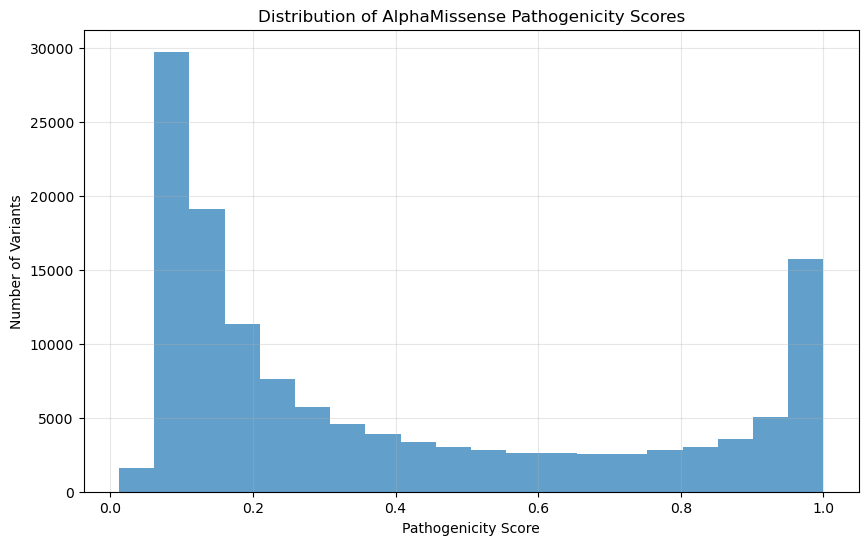

In [76]:
# Save the updated MAF file
output_maf_file = "/Volumes/T7_Shield/Lab/T7_UCSD/github_repos/BENG285_team3/project_2/alphamissense/TCGA.LUAD.with_am_scores.txt"
annotated_maf.to_csv(output_maf_file, sep='\t', index=False)
print(f"Saved updated MAF file to {output_maf_file}")

# Summary statistics
missense_count = (annotated_maf['Variant_Classification'] == 'Missense_Mutation').sum()
missense_with_am = ((annotated_maf['Variant_Classification'] == 'Missense_Mutation') & 
                    annotated_maf['am_pathogenicity'].notna()).sum()

print(f"\nSummary:")
print(f"Total variants: {len(annotated_maf)}")
print(f"Missense mutations: {missense_count}")
print(f"Missense mutations with AM scores: {missense_with_am} ({missense_with_am/missense_count*100:.1f}%)")

# Show distribution of AM scores
if missense_with_am > 0:
    plt.figure(figsize=(10, 6))
    plt.hist(annotated_maf[annotated_maf['am_pathogenicity'].notna()]['am_pathogenicity'], 
             bins=20, alpha=0.7)
    plt.title('Distribution of AlphaMissense Pathogenicity Scores')
    plt.xlabel('Pathogenicity Score')
    plt.ylabel('Number of Variants')
    plt.grid(True, alpha=0.3)
    plt.show()

## Apply Hypermutator Filtering and Calculate Observed DN Score

Following the same filtering approach as in analysis.ipynb, we'll filter out hypermutator samples and calculate the observed_dn_score for each gene.

In [77]:
# Load the output MAF file with AM scores that we just created
print(f"Loading MAF file with AlphaMissense scores from {output_maf_file}")
maf_with_am = pd.read_csv(output_maf_file, sep='\t')
print(f"Loaded {len(maf_with_am)} mutations")

# Count mutations per patient to identify hypermutators
HYPERMUTATOR_THRESHOLD = 500
patient_counts = maf_with_am['patient_id'].value_counts().reset_index()
patient_counts.columns = ['patient_id', 'mutation_count']
hypermutators = patient_counts[patient_counts['mutation_count'] > HYPERMUTATOR_THRESHOLD]['patient_id'].tolist()

print(f"\nFound {len(hypermutators)} hypermutator patients (>{HYPERMUTATOR_THRESHOLD} mutations):")
print(hypermutators[:5], "..." if len(hypermutators) > 5 else "")

# Filter out hypermutator samples
filtered_maf = maf_with_am[~maf_with_am['patient_id'].isin(hypermutators)].copy()
print(f"\nRemoved {len(maf_with_am) - len(filtered_maf)} mutations from hypermutator samples")
print(f"Retained {len(filtered_maf)} mutations from {filtered_maf['patient_id'].nunique()} patients")

# Load the gene results file
print(f"\nLoading gene results from {output_file}")
gene_results = pd.read_csv(output_file)
print(f"Loaded results for {len(gene_results)} genes")

Loading MAF file with AlphaMissense scores from /Volumes/T7_Shield/Lab/T7_UCSD/github_repos/BENG285_team3/project_2/alphamissense/TCGA.LUAD.with_am_scores.txt


/var/folders/m1/hgskz8dj1d53c9ghp7mby_vh0000gn/T/ipykernel_81436/4202410393.py:3: DtypeWarning: Columns (5,53) have mixed types. Specify dtype option on import or set low_memory=False.
  maf_with_am = pd.read_csv(output_maf_file, sep='\t')


Loaded 224355 mutations

Found 158 hypermutator patients (>500 mutations):
['TCGA-44-7670', 'TCGA-44-5644', 'TCGA-44-3918', 'TCGA-55-8506', 'TCGA-44-2656'] ...

Removed 152884 mutations from hypermutator samples
Retained 71471 mutations from 354 patients

Loading gene results from /Volumes/T7_Shield/Lab/T7_UCSD/github_repos/BENG285_team3/project_2/alphamissense/gene_results_with_am_scores.csv
Loaded results for 15520 genes


In [78]:
# Calculate observed_dn_score for each gene
# This is sum of am_pathogenicity scores plus number of nonsense mutations

# First, make sure we have am_pathogenicity value as float
filtered_maf['am_pathogenicity'] = pd.to_numeric(filtered_maf['am_pathogenicity'], errors='coerce')

# Group by gene and calculate the observed scores
gene_scores = filtered_maf.groupby('Hugo_Symbol').apply(lambda x: {
    'observed_mis_am_score': x[x['Variant_Classification'] == 'Missense_Mutation']['am_pathogenicity'].sum(),
    'observed_nonsense_count': (x['Variant_Classification'] == 'Nonsense_Mutation').sum(),
    'observed_splice_count': x['Variant_Classification'].isin(['Splice_Site', 'Splice_Region']).sum(),
    'total_mutations': len(x)
}).apply(pd.Series)

# Calculate observed_dn_score as sum of observed_mis_am_score + observed_nonsense_count
gene_scores['observed_dn_score'] = gene_scores['observed_mis_am_score'] + gene_scores['observed_nonsense_count']

# Fill NaN values with 0
gene_scores = gene_scores.fillna(0)

print("\nCalculated scores for genes:")
print(gene_scores.head())

/var/folders/m1/hgskz8dj1d53c9ghp7mby_vh0000gn/T/ipykernel_81436/4276556868.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gene_scores = filtered_maf.groupby('Hugo_Symbol').apply(lambda x: {



Calculated scores for genes:
             observed_mis_am_score  observed_nonsense_count  \
Hugo_Symbol                                                   
A1BG                        0.0000                      0.0   
A1CF                        1.9952                      0.0   
A2M                         2.9760                      0.0   
A2ML1                       2.1617                      0.0   
A4GNT                       0.1782                      0.0   

             observed_splice_count  total_mutations  observed_dn_score  
Hugo_Symbol                                                             
A1BG                           0.0              2.0             0.0000  
A1CF                           1.0              8.0             1.9952  
A2M                            0.0              6.0             2.9760  
A2ML1                          0.0             11.0             2.1617  
A4GNT                          0.0              1.0             0.1782  


In [79]:
# Merge the observed scores with gene_results
merged_results = pd.merge(
    gene_results,
    gene_scores,
    left_on='gene_name',
    right_index=True,
    how='left'
)

# Fill NaN values with 0 for any genes not found in the MAF
merged_results[['observed_mis_am_score', 'observed_nonsense_count', 'observed_splice_count', 
                'total_mutations', 'observed_dn_score']] = merged_results[[
                    'observed_mis_am_score', 'observed_nonsense_count', 'observed_splice_count', 
                    'total_mutations', 'observed_dn_score']].fillna(0)

print("\nMerged observed scores with gene results:")
print(f"Found matching scores for {(merged_results['total_mutations'] > 0).sum()} genes")
print("Sample of merged data:")
print(merged_results[['gene_name', 'n_mis', 'n_non', 'exp_mis_scores', 
                      'observed_mis_am_score', 'observed_nonsense_count', 'observed_dn_score']].head())


Merged observed scores with gene results:
Found matching scores for 15520 genes
Sample of merged data:
  gene_name  n_mis  n_non  exp_mis_scores  observed_mis_am_score  \
0      KRAS    112      1       1725.7586               111.0805   
1      TP53     94     25       1120.5145                82.0906   
2     KEAP1     46      8       2161.5357                41.6035   
3      EGFR     44      1       7976.3108                39.7970   
4     STK11     21     14       3284.3718                19.2695   

   observed_nonsense_count  observed_dn_score  
0                      1.0           112.0805  
1                     25.0           107.0906  
2                      8.0            49.6035  
3                      1.0            40.7970  
4                     14.0            33.2695  


In [80]:
# Calculate additional statistics
# - Ratio of observed_dn_score to exp_dn_score
merged_results['obs_exp_dn_ratio'] = merged_results['observed_dn_score'] / merged_results['exp_dn_score'].replace(0, float('nan'))

# Save the updated results
final_output_file = "/Volumes/T7_Shield/Lab/T7_UCSD/github_repos/BENG285_team3/project_2/alphamissense/gene_results_with_observed_dn_scores.csv"
merged_results.to_csv(final_output_file, index=False)
print(f"\nSaved updated gene results with observed_dn_score to {final_output_file}")

# Display summary statistics of the ratios
ratio_stats = merged_results['obs_exp_dn_ratio'].describe()
print("\nSummary of observed/expected DN ratio:")
print(ratio_stats)

# Find top genes by observed/expected ratio (with at least some mutations)
top_genes = merged_results[
    (merged_results['total_mutations'] >= 5) & 
    (merged_results['obs_exp_dn_ratio'].notnull())
].sort_values('obs_exp_dn_ratio', ascending=False).head(20)

print("\nTop 20 genes by observed/expected DN score ratio (min 5 mutations):")
print(top_genes[['gene_name', 'total_mutations', 'observed_dn_score', 'exp_dn_score', 'obs_exp_dn_ratio']])


Saved updated gene results with observed_dn_score to /Volumes/T7_Shield/Lab/T7_UCSD/github_repos/BENG285_team3/project_2/alphamissense/gene_results_with_observed_dn_scores.csv

Summary of observed/expected DN ratio:
count    15520.000000
mean         0.000515
std          0.001380
min          0.000000
25%          0.000069
50%          0.000256
75%          0.000560
max          0.057514
Name: obs_exp_dn_ratio, dtype: float64

Top 20 genes by observed/expected DN score ratio (min 5 mutations):
         gene_name  total_mutations  observed_dn_score  exp_dn_score  \
0             KRAS            113.0           112.0805     1948.7586   
1             TP53            152.0           107.0906     2090.5145   
691        TRBV7-8              6.0             2.0000       42.0000   
13037  IGHV1OR21-1             10.0             2.3545       75.0000   
12187        VEGFC             12.0             4.6102      191.0000   
732           IGHD              6.0             3.1169      150.000

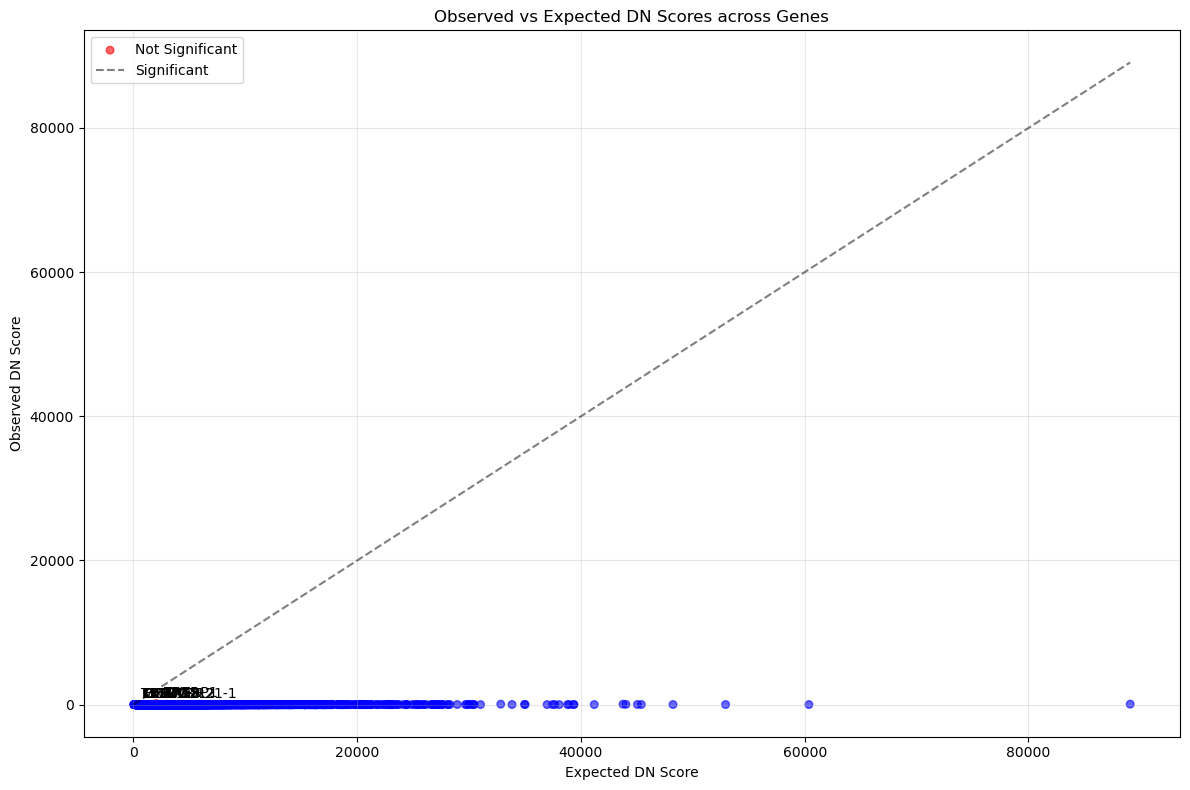

In [81]:
# Visualize the distribution of observed_dn_score vs exp_dn_score
plt.figure(figsize=(12, 8))

# Plot genes with at least 5 total mutations
plot_data = merged_results[merged_results['total_mutations'] >= 5].copy()

# Add a column to identify significant genes
if 'significant' in plot_data.columns:
    plot_data['color'] = plot_data['significant'].map({True: 'red', False: 'blue'})
    legend_labels = ['Not Significant', 'Significant']
else:
    plot_data['color'] = 'blue'
    legend_labels = None

# Create scatter plot
plt.scatter(
    plot_data['exp_dn_score'], 
    plot_data['observed_dn_score'],
    c=plot_data['color'], 
    alpha=0.6, 
    s=30
)

# Add reference line
max_val = max(plot_data['exp_dn_score'].max(), plot_data['observed_dn_score'].max())
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)

# Add labels for top genes
for i, row in plot_data.nlargest(10, 'obs_exp_dn_ratio').iterrows():
    plt.annotate(row['gene_name'], 
                 (row['exp_dn_score'], row['observed_dn_score']),
                 xytext=(5, 5), textcoords='offset points')

# Formatting
plt.xlabel('Expected DN Score')
plt.ylabel('Observed DN Score')
plt.title('Observed vs Expected DN Scores across Genes')
if legend_labels:
    plt.legend(legend_labels)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()